In [1]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

In [14]:

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]


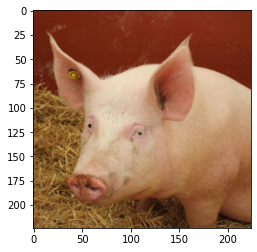

In [15]:

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))


In [16]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();


In [17]:
pred = model(norm(pig_tensor))

In [18]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print("%s (%d)" % (imagenet_classes[pred.max(dim=1)[1].item()], pred.max(dim=1)[1].item()))


hog (341)


## Creating an adversary example

In [134]:
import torch.optim as optim
import numpy as np
from scipy import stats
import time

def candidate_to_mask(cand, img):
    msk = torch.clone(img)
    for tpl in cand:
        y = int(tpl[0])
        x = int(tpl[1])
        msk[0,0,y,x] = tpl[2]
        msk[0,1,y,x] = tpl[3]
        msk[0,2,y,x] = tpl[4]
    msk.data.clip_(0,1)
    return msk

def random_cand(shape, num_tpls):
    return [np.concatenate((np.random.randint(0, shape[2], 2), np.random.normal(0.5, 0.5, 3))) for x in range(num_tpls)]

def crossover(x, cand1, cand2, cand3, F, CR, shape):
    Rtpl = np.random.randint(0, len(cand1))
    R   = np.random.randint(0,5)
    tpls = []
    for i, tpl in enumerate(cand1):
        co_idx = np.random.binomial(1, CR, 5)
        if i == R:
            co_idx[R] = 1
        new_tpl = np.clip(x[i]*(1-co_idx) + (cand1[i] + F*(cand2[i] - cand3[i]))*co_idx,
                          0, [shape[2]-1, shape[2]-1, 1, 1, 1])
        new_tpl[0:2] = np.round(new_tpl[0:2])
        tpls.append(new_tpl)
    return tpls



In [117]:
NC = 100
train_against_label = 341
CR = .9
F  = .8
num_pixels = 20

candidates = [random_cand(pig_tensor.shape, num_pixels) for i in range(NC)]
losses = np.zeros(NC)

In [137]:
for it in range(2000):
    start = time.time()
    print("Iteration %d" % it)
    for i, cand in enumerate(candidates):

        pred = model(norm(candidate_to_mask(cand, pig_tensor)))
        loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([train_against_label]))

        co_cands = np.random.randint(0, NC, 3)
        co_prop = crossover(cand, candidates[co_cands[0]], candidates[co_cands[1]], candidates[co_cands[2]], F, CR, pig_tensor.shape)
        pred_prop = model(norm(candidate_to_mask(co_prop, pig_tensor)))
        loss_prop = -nn.CrossEntropyLoss()(pred_prop, torch.LongTensor([train_against_label]))

        if loss_prop < loss:
            candidates[i] = co_prop
            losses[i] = loss_prop
        else:
            losses[i] = loss
    print("Minimum loss: %f (candidate %d)" % (losses[np.argmin(losses)], np.argmin(losses)))
    print("True class probability:", nn.Softmax(dim=1)(model(norm(candidate_to_mask(candidates[np.argmin(losses)], pig_tensor))))[0,train_against_label].item())
    print("Current candidate loss distribution: μ=%f σ=%f" % (np.mean(losses), np.std(losses)))
    print("Elapsed time: %fs" % (time.time() - start))

Iteration 0
Minimum loss: -0.006546 (candidate 26)
True class probability: 0.9934750199317932
Current candidate loss distribution: μ=-0.005091 σ=0.000388
Elapsed time: 17.719782s
Iteration 1
Minimum loss: -0.006546 (candidate 26)
True class probability: 0.9934750199317932
Current candidate loss distribution: μ=-0.005099 σ=0.000391
Elapsed time: 17.705860s
Iteration 2
Minimum loss: -0.006546 (candidate 26)
True class probability: 0.9934750199317932
Current candidate loss distribution: μ=-0.005099 σ=0.000391
Elapsed time: 17.746792s
Iteration 3
Minimum loss: -0.006546 (candidate 26)
True class probability: 0.9934750199317932
Current candidate loss distribution: μ=-0.005102 σ=0.000391
Elapsed time: 17.268335s
Iteration 4
Minimum loss: -0.006546 (candidate 26)
True class probability: 0.9934750199317932
Current candidate loss distribution: μ=-0.005102 σ=0.000391
Elapsed time: 16.913324s
Iteration 5
Minimum loss: -0.006546 (candidate 26)
True class probability: 0.9934750199317932
Current can

Minimum loss: -0.006592 (candidate 57)
True class probability: 0.9934294819831848
Current candidate loss distribution: μ=-0.005224 σ=0.000443
Elapsed time: 17.360899s
Iteration 47
Minimum loss: -0.006592 (candidate 57)
True class probability: 0.9934294819831848
Current candidate loss distribution: μ=-0.005228 σ=0.000438
Elapsed time: 16.886994s
Iteration 48
Minimum loss: -0.006592 (candidate 57)
True class probability: 0.9934294819831848
Current candidate loss distribution: μ=-0.005230 σ=0.000438
Elapsed time: 17.035854s
Iteration 49
Minimum loss: -0.006592 (candidate 57)
True class probability: 0.9934294819831848
Current candidate loss distribution: μ=-0.005230 σ=0.000438
Elapsed time: 17.038312s
Iteration 50
Minimum loss: -0.006592 (candidate 57)
True class probability: 0.9934294819831848
Current candidate loss distribution: μ=-0.005232 σ=0.000439
Elapsed time: 17.127169s
Iteration 51
Minimum loss: -0.006592 (candidate 57)
True class probability: 0.9934294819831848
Current candidate 

Minimum loss: -0.006592 (candidate 57)
True class probability: 0.9934294819831848
Current candidate loss distribution: μ=-0.005374 σ=0.000439
Elapsed time: 16.962372s
Iteration 93
Minimum loss: -0.006592 (candidate 57)
True class probability: 0.9934294819831848
Current candidate loss distribution: μ=-0.005374 σ=0.000439
Elapsed time: 16.569466s
Iteration 94
Minimum loss: -0.006592 (candidate 57)
True class probability: 0.9934294819831848
Current candidate loss distribution: μ=-0.005375 σ=0.000438
Elapsed time: 16.982500s
Iteration 95
Minimum loss: -0.006592 (candidate 57)
True class probability: 0.9934294819831848
Current candidate loss distribution: μ=-0.005375 σ=0.000438
Elapsed time: 16.525309s
Iteration 96
Minimum loss: -0.006592 (candidate 57)
True class probability: 0.9934294819831848
Current candidate loss distribution: μ=-0.005381 σ=0.000438
Elapsed time: 16.543807s
Iteration 97
Minimum loss: -0.006592 (candidate 57)
True class probability: 0.9934294819831848
Current candidate 

Minimum loss: -0.007436 (candidate 17)
True class probability: 0.9925919771194458
Current candidate loss distribution: μ=-0.005605 σ=0.000557
Elapsed time: 16.856685s
Iteration 139
Minimum loss: -0.007436 (candidate 17)
True class probability: 0.9925919771194458
Current candidate loss distribution: μ=-0.005619 σ=0.000554
Elapsed time: 16.869900s
Iteration 140
Minimum loss: -0.007436 (candidate 17)
True class probability: 0.9925919771194458
Current candidate loss distribution: μ=-0.005630 σ=0.000548
Elapsed time: 16.712076s
Iteration 141
Minimum loss: -0.007436 (candidate 17)
True class probability: 0.9925919771194458
Current candidate loss distribution: μ=-0.005637 σ=0.000548
Elapsed time: 16.594046s
Iteration 142
Minimum loss: -0.007436 (candidate 17)
True class probability: 0.9925919771194458
Current candidate loss distribution: μ=-0.005646 σ=0.000545
Elapsed time: 16.529419s
Iteration 143
Minimum loss: -0.007436 (candidate 17)
True class probability: 0.9925919771194458
Current candi

Minimum loss: -0.008286 (candidate 37)
True class probability: 0.991748571395874
Current candidate loss distribution: μ=-0.006422 σ=0.000515
Elapsed time: 16.838176s
Iteration 185
Minimum loss: -0.008286 (candidate 37)
True class probability: 0.991748571395874
Current candidate loss distribution: μ=-0.006444 σ=0.000518
Elapsed time: 16.742135s
Iteration 186
Minimum loss: -0.008286 (candidate 37)
True class probability: 0.991748571395874
Current candidate loss distribution: μ=-0.006483 σ=0.000523
Elapsed time: 16.840091s
Iteration 187
Minimum loss: -0.008286 (candidate 37)
True class probability: 0.991748571395874
Current candidate loss distribution: μ=-0.006489 σ=0.000518
Elapsed time: 16.796906s
Iteration 188
Minimum loss: -0.008286 (candidate 37)
True class probability: 0.991748571395874
Current candidate loss distribution: μ=-0.006508 σ=0.000507
Elapsed time: 16.690083s
Iteration 189
Minimum loss: -0.008286 (candidate 37)
True class probability: 0.991748571395874
Current candidate l

Minimum loss: -0.008286 (candidate 37)
True class probability: 0.991748571395874
Current candidate loss distribution: μ=-0.006875 σ=0.000383
Elapsed time: 16.808537s
Iteration 231
Minimum loss: -0.008286 (candidate 37)
True class probability: 0.991748571395874
Current candidate loss distribution: μ=-0.006875 σ=0.000383
Elapsed time: 16.714191s
Iteration 232
Minimum loss: -0.008286 (candidate 37)
True class probability: 0.991748571395874
Current candidate loss distribution: μ=-0.006878 σ=0.000379
Elapsed time: 16.804114s
Iteration 233
Minimum loss: -0.008286 (candidate 37)
True class probability: 0.991748571395874
Current candidate loss distribution: μ=-0.006878 σ=0.000379
Elapsed time: 17.221326s
Iteration 234
Minimum loss: -0.008286 (candidate 37)
True class probability: 0.991748571395874
Current candidate loss distribution: μ=-0.006878 σ=0.000379
Elapsed time: 17.230922s
Iteration 235
Minimum loss: -0.008286 (candidate 37)
True class probability: 0.991748571395874
Current candidate l

Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007030 σ=0.000402
Elapsed time: 16.851529s
Iteration 277
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007034 σ=0.000400
Elapsed time: 16.876974s
Iteration 278
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007037 σ=0.000397
Elapsed time: 16.806036s
Iteration 279
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007037 σ=0.000397
Elapsed time: 16.760028s
Iteration 280
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007037 σ=0.000397
Elapsed time: 16.849009s
Iteration 281
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candi

Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007164 σ=0.000411
Elapsed time: 16.818205s
Iteration 323
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007170 σ=0.000405
Elapsed time: 16.786514s
Iteration 324
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007170 σ=0.000405
Elapsed time: 17.012529s
Iteration 325
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007174 σ=0.000405
Elapsed time: 16.939522s
Iteration 326
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007190 σ=0.000416
Elapsed time: 16.912861s
Iteration 327
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candi

Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007377 σ=0.000415
Elapsed time: 16.837926s
Iteration 369
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007380 σ=0.000412
Elapsed time: 16.638863s
Iteration 370
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007380 σ=0.000412
Elapsed time: 16.824998s
Iteration 371
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007380 σ=0.000412
Elapsed time: 16.823411s
Iteration 372
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candidate loss distribution: μ=-0.007386 σ=0.000408
Elapsed time: 16.857128s
Iteration 373
Minimum loss: -0.008314 (candidate 17)
True class probability: 0.9917205572128296
Current candi

Minimum loss: -0.008466 (candidate 24)
True class probability: 0.9915697574615479
Current candidate loss distribution: μ=-0.007518 σ=0.000377
Elapsed time: 16.959798s
Iteration 415
Minimum loss: -0.008466 (candidate 24)
True class probability: 0.9915697574615479
Current candidate loss distribution: μ=-0.007518 σ=0.000377
Elapsed time: 16.858396s
Iteration 416
Minimum loss: -0.008466 (candidate 24)
True class probability: 0.9915697574615479
Current candidate loss distribution: μ=-0.007518 σ=0.000377
Elapsed time: 16.899448s
Iteration 417
Minimum loss: -0.008466 (candidate 24)
True class probability: 0.9915697574615479
Current candidate loss distribution: μ=-0.007520 σ=0.000377
Elapsed time: 16.897877s
Iteration 418
Minimum loss: -0.008466 (candidate 24)
True class probability: 0.9915697574615479
Current candidate loss distribution: μ=-0.007530 σ=0.000379
Elapsed time: 17.191593s
Iteration 419
Minimum loss: -0.008466 (candidate 24)
True class probability: 0.9915697574615479
Current candi

Minimum loss: -0.008788 (candidate 8)
True class probability: 0.9912505149841309
Current candidate loss distribution: μ=-0.007649 σ=0.000382
Elapsed time: 16.800325s
Iteration 461
Minimum loss: -0.008788 (candidate 8)
True class probability: 0.9912505149841309
Current candidate loss distribution: μ=-0.007655 σ=0.000387
Elapsed time: 16.829592s
Iteration 462
Minimum loss: -0.008788 (candidate 8)
True class probability: 0.9912505149841309
Current candidate loss distribution: μ=-0.007655 σ=0.000387
Elapsed time: 16.964935s
Iteration 463
Minimum loss: -0.008788 (candidate 8)
True class probability: 0.9912505149841309
Current candidate loss distribution: μ=-0.007655 σ=0.000387
Elapsed time: 16.942096s
Iteration 464
Minimum loss: -0.008788 (candidate 8)
True class probability: 0.9912505149841309
Current candidate loss distribution: μ=-0.007655 σ=0.000387
Elapsed time: 16.829025s
Iteration 465
Minimum loss: -0.008788 (candidate 8)
True class probability: 0.9912505149841309
Current candidate l

Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.007764 σ=0.000416
Elapsed time: 16.877872s
Iteration 507
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.007771 σ=0.000413
Elapsed time: 16.803343s
Iteration 508
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.007772 σ=0.000412
Elapsed time: 16.872484s
Iteration 509
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.007774 σ=0.000413
Elapsed time: 16.928246s
Iteration 510
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.007775 σ=0.000413
Elapsed time: 16.898523s
Iteration 511
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candi

Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.007909 σ=0.000416
Elapsed time: 16.868141s
Iteration 553
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.007913 σ=0.000414
Elapsed time: 16.799300s
Iteration 554
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.007913 σ=0.000414
Elapsed time: 16.807479s
Iteration 555
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.007917 σ=0.000410
Elapsed time: 16.850081s
Iteration 556
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.007917 σ=0.000410
Elapsed time: 16.870234s
Iteration 557
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candi

Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.008052 σ=0.000400
Elapsed time: 16.885109s
Iteration 599
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.008052 σ=0.000400
Elapsed time: 16.862165s
Iteration 600
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.008058 σ=0.000400
Elapsed time: 16.829919s
Iteration 601
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.008058 σ=0.000400
Elapsed time: 16.833052s
Iteration 602
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candidate loss distribution: μ=-0.008058 σ=0.000400
Elapsed time: 16.855523s
Iteration 603
Minimum loss: -0.009187 (candidate 90)
True class probability: 0.9908547401428223
Current candi

Minimum loss: -0.009574 (candidate 96)
True class probability: 0.9904719591140747
Current candidate loss distribution: μ=-0.008186 σ=0.000441
Elapsed time: 16.977697s
Iteration 645
Minimum loss: -0.009574 (candidate 96)
True class probability: 0.9904719591140747
Current candidate loss distribution: μ=-0.008187 σ=0.000440
Elapsed time: 17.031940s
Iteration 646
Minimum loss: -0.009574 (candidate 96)
True class probability: 0.9904719591140747
Current candidate loss distribution: μ=-0.008187 σ=0.000440
Elapsed time: 16.880243s
Iteration 647
Minimum loss: -0.009574 (candidate 96)
True class probability: 0.9904719591140747
Current candidate loss distribution: μ=-0.008194 σ=0.000437
Elapsed time: 17.020114s
Iteration 648
Minimum loss: -0.009574 (candidate 96)
True class probability: 0.9904719591140747
Current candidate loss distribution: μ=-0.008204 σ=0.000444
Elapsed time: 16.834902s
Iteration 649
Minimum loss: -0.009574 (candidate 96)
True class probability: 0.9904719591140747
Current candi

Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008398 σ=0.000504
Elapsed time: 16.862633s
Iteration 691
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008398 σ=0.000504
Elapsed time: 16.986597s
Iteration 692
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008398 σ=0.000504
Elapsed time: 16.877249s
Iteration 693
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008413 σ=0.000509
Elapsed time: 16.837275s
Iteration 694
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008413 σ=0.000509
Elapsed time: 16.935938s
Iteration 695
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candi

Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008576 σ=0.000521
Elapsed time: 16.940165s
Iteration 737
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008576 σ=0.000521
Elapsed time: 16.839585s
Iteration 738
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008577 σ=0.000521
Elapsed time: 16.885417s
Iteration 739
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008584 σ=0.000507
Elapsed time: 16.922049s
Iteration 740
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008584 σ=0.000507
Elapsed time: 17.185086s
Iteration 741
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candi

Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008713 σ=0.000504
Elapsed time: 16.915748s
Iteration 783
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008713 σ=0.000504
Elapsed time: 16.922257s
Iteration 784
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008713 σ=0.000504
Elapsed time: 16.877312s
Iteration 785
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008713 σ=0.000504
Elapsed time: 16.953489s
Iteration 786
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candidate loss distribution: μ=-0.008713 σ=0.000504
Elapsed time: 17.046643s
Iteration 787
Minimum loss: -0.010403 (candidate 50)
True class probability: 0.9896509647369385
Current candi

Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.008938 σ=0.000535
Elapsed time: 16.871845s
Iteration 829
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.008948 σ=0.000540
Elapsed time: 16.870673s
Iteration 830
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.008958 σ=0.000553
Elapsed time: 16.888799s
Iteration 831
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.008958 σ=0.000553
Elapsed time: 16.950660s
Iteration 832
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.008982 σ=0.000568
Elapsed time: 16.880504s
Iteration 833
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candi

Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.009176 σ=0.000524
Elapsed time: 17.520030s
Iteration 875
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.009181 σ=0.000521
Elapsed time: 16.884142s
Iteration 876
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.009181 σ=0.000521
Elapsed time: 16.826749s
Iteration 877
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.009184 σ=0.000521
Elapsed time: 16.857023s
Iteration 878
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.009184 σ=0.000521
Elapsed time: 16.968925s
Iteration 879
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candi

Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.009332 σ=0.000500
Elapsed time: 16.857243s
Iteration 921
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.009332 σ=0.000500
Elapsed time: 16.861758s
Iteration 922
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.009332 σ=0.000500
Elapsed time: 16.869642s
Iteration 923
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.009332 σ=0.000499
Elapsed time: 16.836378s
Iteration 924
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candidate loss distribution: μ=-0.009332 σ=0.000499
Elapsed time: 16.929454s
Iteration 925
Minimum loss: -0.010624 (candidate 36)
True class probability: 0.9894320964813232
Current candi

Minimum loss: -0.011330 (candidate 91)
True class probability: 0.9887343645095825
Current candidate loss distribution: μ=-0.009563 σ=0.000526
Elapsed time: 17.180021s
Iteration 967
Minimum loss: -0.011330 (candidate 91)
True class probability: 0.9887343645095825
Current candidate loss distribution: μ=-0.009575 σ=0.000526
Elapsed time: 16.899013s
Iteration 968
Minimum loss: -0.011330 (candidate 91)
True class probability: 0.9887343645095825
Current candidate loss distribution: μ=-0.009575 σ=0.000526
Elapsed time: 16.936918s
Iteration 969
Minimum loss: -0.011330 (candidate 91)
True class probability: 0.9887343645095825
Current candidate loss distribution: μ=-0.009582 σ=0.000526
Elapsed time: 16.833876s
Iteration 970
Minimum loss: -0.011330 (candidate 91)
True class probability: 0.9887343645095825
Current candidate loss distribution: μ=-0.009591 σ=0.000520
Elapsed time: 16.934794s
Iteration 971
Minimum loss: -0.011330 (candidate 91)
True class probability: 0.9887343645095825
Current candi

Minimum loss: -0.011870 (candidate 11)
True class probability: 0.9881997108459473
Current candidate loss distribution: μ=-0.009820 σ=0.000565
Elapsed time: 16.818298s
Iteration 1013
Minimum loss: -0.011870 (candidate 11)
True class probability: 0.9881997108459473
Current candidate loss distribution: μ=-0.009832 σ=0.000559
Elapsed time: 16.870888s
Iteration 1014
Minimum loss: -0.011870 (candidate 11)
True class probability: 0.9881997108459473
Current candidate loss distribution: μ=-0.009832 σ=0.000559
Elapsed time: 16.839469s
Iteration 1015
Minimum loss: -0.011870 (candidate 11)
True class probability: 0.9881997108459473
Current candidate loss distribution: μ=-0.009849 σ=0.000569
Elapsed time: 16.845841s
Iteration 1016
Minimum loss: -0.011870 (candidate 11)
True class probability: 0.9881997108459473
Current candidate loss distribution: μ=-0.009861 σ=0.000566
Elapsed time: 16.873169s
Iteration 1017
Minimum loss: -0.011870 (candidate 11)
True class probability: 0.9881997108459473
Current 

Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010087 σ=0.000587
Elapsed time: 16.815557s
Iteration 1059
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010108 σ=0.000581
Elapsed time: 16.948531s
Iteration 1060
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010110 σ=0.000581
Elapsed time: 17.163895s
Iteration 1061
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010116 σ=0.000574
Elapsed time: 16.914910s
Iteration 1062
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010117 σ=0.000573
Elapsed time: 16.795176s
Iteration 1063
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current 

Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010361 σ=0.000539
Elapsed time: 16.794215s
Iteration 1105
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010369 σ=0.000539
Elapsed time: 16.914371s
Iteration 1106
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010371 σ=0.000540
Elapsed time: 16.873502s
Iteration 1107
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010371 σ=0.000540
Elapsed time: 16.876812s
Iteration 1108
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010371 σ=0.000540
Elapsed time: 16.965253s
Iteration 1109
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current 

Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010542 σ=0.000548
Elapsed time: 16.801418s
Iteration 1151
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010544 σ=0.000547
Elapsed time: 16.787297s
Iteration 1152
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010544 σ=0.000547
Elapsed time: 16.806685s
Iteration 1153
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010546 σ=0.000548
Elapsed time: 16.813082s
Iteration 1154
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current candidate loss distribution: μ=-0.010546 σ=0.000548
Elapsed time: 16.759518s
Iteration 1155
Minimum loss: -0.011976 (candidate 29)
True class probability: 0.9880958795547485
Current 

Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.010728 σ=0.000643
Elapsed time: 16.822974s
Iteration 1197
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.010728 σ=0.000643
Elapsed time: 16.787589s
Iteration 1198
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.010728 σ=0.000643
Elapsed time: 16.778942s
Iteration 1199
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.010739 σ=0.000647
Elapsed time: 16.822406s
Iteration 1200
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.010744 σ=0.000650
Elapsed time: 16.806626s
Iteration 1201
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current 

Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.010966 σ=0.000650
Elapsed time: 16.771742s
Iteration 1243
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.010966 σ=0.000650
Elapsed time: 16.770267s
Iteration 1244
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.010966 σ=0.000650
Elapsed time: 16.767681s
Iteration 1245
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.010972 σ=0.000646
Elapsed time: 16.831779s
Iteration 1246
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.010976 σ=0.000651
Elapsed time: 16.805392s
Iteration 1247
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current 

Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.011203 σ=0.000605
Elapsed time: 16.791431s
Iteration 1289
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.011203 σ=0.000605
Elapsed time: 16.726880s
Iteration 1290
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.011211 σ=0.000600
Elapsed time: 16.804915s
Iteration 1291
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.011224 σ=0.000602
Elapsed time: 16.800156s
Iteration 1292
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current candidate loss distribution: μ=-0.011234 σ=0.000600
Elapsed time: 16.759507s
Iteration 1293
Minimum loss: -0.013222 (candidate 68)
True class probability: 0.9868649840354919
Current 

Minimum loss: -0.013273 (candidate 87)
True class probability: 0.9868150949478149
Current candidate loss distribution: μ=-0.011506 σ=0.000612
Elapsed time: 16.842456s
Iteration 1335
Minimum loss: -0.013273 (candidate 87)
True class probability: 0.9868150949478149
Current candidate loss distribution: μ=-0.011529 σ=0.000612
Elapsed time: 16.816862s
Iteration 1336
Minimum loss: -0.013273 (candidate 87)
True class probability: 0.9868150949478149
Current candidate loss distribution: μ=-0.011529 σ=0.000612
Elapsed time: 16.803766s
Iteration 1337
Minimum loss: -0.013273 (candidate 87)
True class probability: 0.9868150949478149
Current candidate loss distribution: μ=-0.011544 σ=0.000601
Elapsed time: 16.881778s
Iteration 1338
Minimum loss: -0.013273 (candidate 87)
True class probability: 0.9868150949478149
Current candidate loss distribution: μ=-0.011549 σ=0.000598
Elapsed time: 16.981366s
Iteration 1339
Minimum loss: -0.013273 (candidate 87)
True class probability: 0.9868150949478149
Current 

Minimum loss: -0.013273 (candidate 87)
True class probability: 0.9868150949478149
Current candidate loss distribution: μ=-0.011857 σ=0.000583
Elapsed time: 16.857105s
Iteration 1381
Minimum loss: -0.013273 (candidate 87)
True class probability: 0.9868150949478149
Current candidate loss distribution: μ=-0.011857 σ=0.000583
Elapsed time: 16.774455s
Iteration 1382
Minimum loss: -0.013273 (candidate 87)
True class probability: 0.9868150949478149
Current candidate loss distribution: μ=-0.011857 σ=0.000583
Elapsed time: 17.046481s
Iteration 1383
Minimum loss: -0.013273 (candidate 87)
True class probability: 0.9868150949478149
Current candidate loss distribution: μ=-0.011865 σ=0.000585
Elapsed time: 16.823833s
Iteration 1384
Minimum loss: -0.013273 (candidate 87)
True class probability: 0.9868150949478149
Current candidate loss distribution: μ=-0.011868 σ=0.000584
Elapsed time: 16.827442s
Iteration 1385
Minimum loss: -0.013273 (candidate 87)
True class probability: 0.9868150949478149
Current 

Minimum loss: -0.013273 (candidate 87)
True class probability: 0.9868150949478149
Current candidate loss distribution: μ=-0.012045 σ=0.000540
Elapsed time: 16.880315s
Iteration 1427
Minimum loss: -0.013273 (candidate 87)
True class probability: 0.9868150949478149
Current candidate loss distribution: μ=-0.012048 σ=0.000536
Elapsed time: 16.950284s
Iteration 1428
Minimum loss: -0.013413 (candidate 33)
True class probability: 0.9866763353347778
Current candidate loss distribution: μ=-0.012063 σ=0.000547
Elapsed time: 17.000906s
Iteration 1429
Minimum loss: -0.013413 (candidate 33)
True class probability: 0.9866763353347778
Current candidate loss distribution: μ=-0.012063 σ=0.000547
Elapsed time: 16.798525s
Iteration 1430
Minimum loss: -0.013413 (candidate 33)
True class probability: 0.9866763353347778
Current candidate loss distribution: μ=-0.012070 σ=0.000545
Elapsed time: 16.838425s
Iteration 1431
Minimum loss: -0.013413 (candidate 33)
True class probability: 0.9866763353347778
Current 

Minimum loss: -0.013957 (candidate 87)
True class probability: 0.9861395359039307
Current candidate loss distribution: μ=-0.012288 σ=0.000562
Elapsed time: 16.838061s
Iteration 1473
Minimum loss: -0.013957 (candidate 87)
True class probability: 0.9861395359039307
Current candidate loss distribution: μ=-0.012292 σ=0.000559
Elapsed time: 16.835138s
Iteration 1474
Minimum loss: -0.013957 (candidate 87)
True class probability: 0.9861395359039307
Current candidate loss distribution: μ=-0.012318 σ=0.000576
Elapsed time: 16.864000s
Iteration 1475
Minimum loss: -0.014321 (candidate 78)
True class probability: 0.9857814908027649
Current candidate loss distribution: μ=-0.012354 σ=0.000605
Elapsed time: 16.785783s
Iteration 1476
Minimum loss: -0.014321 (candidate 78)
True class probability: 0.9857814908027649
Current candidate loss distribution: μ=-0.012356 σ=0.000604
Elapsed time: 16.779826s
Iteration 1477
Minimum loss: -0.014321 (candidate 78)
True class probability: 0.9857814908027649
Current 

Minimum loss: -0.014327 (candidate 89)
True class probability: 0.9857747554779053
Current candidate loss distribution: μ=-0.012686 σ=0.000644
Elapsed time: 16.794146s
Iteration 1519
Minimum loss: -0.014327 (candidate 89)
True class probability: 0.9857747554779053
Current candidate loss distribution: μ=-0.012702 σ=0.000628
Elapsed time: 16.794026s
Iteration 1520
Minimum loss: -0.014327 (candidate 89)
True class probability: 0.9857747554779053
Current candidate loss distribution: μ=-0.012702 σ=0.000628
Elapsed time: 16.829152s
Iteration 1521
Minimum loss: -0.014327 (candidate 89)
True class probability: 0.9857747554779053
Current candidate loss distribution: μ=-0.012702 σ=0.000628
Elapsed time: 16.822044s
Iteration 1522
Minimum loss: -0.014327 (candidate 89)
True class probability: 0.9857747554779053
Current candidate loss distribution: μ=-0.012723 σ=0.000634
Elapsed time: 16.788357s
Iteration 1523
Minimum loss: -0.014327 (candidate 89)
True class probability: 0.9857747554779053
Current 

Minimum loss: -0.014518 (candidate 81)
True class probability: 0.985586404800415
Current candidate loss distribution: μ=-0.013101 σ=0.000698
Elapsed time: 16.720155s
Iteration 1565
Minimum loss: -0.014518 (candidate 81)
True class probability: 0.985586404800415
Current candidate loss distribution: μ=-0.013101 σ=0.000698
Elapsed time: 16.855085s
Iteration 1566
Minimum loss: -0.014518 (candidate 81)
True class probability: 0.985586404800415
Current candidate loss distribution: μ=-0.013101 σ=0.000698
Elapsed time: 16.785112s
Iteration 1567
Minimum loss: -0.014518 (candidate 81)
True class probability: 0.985586404800415
Current candidate loss distribution: μ=-0.013101 σ=0.000698
Elapsed time: 16.814261s
Iteration 1568
Minimum loss: -0.014518 (candidate 81)
True class probability: 0.985586404800415
Current candidate loss distribution: μ=-0.013101 σ=0.000698
Elapsed time: 16.837826s
Iteration 1569
Minimum loss: -0.014518 (candidate 81)
True class probability: 0.985586404800415
Current candid

Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013279 σ=0.000780
Elapsed time: 16.747657s
Iteration 1611
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013279 σ=0.000780
Elapsed time: 16.833701s
Iteration 1612
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013283 σ=0.000778
Elapsed time: 16.777051s
Iteration 1613
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013287 σ=0.000781
Elapsed time: 16.741812s
Iteration 1614
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013290 σ=0.000779
Elapsed time: 16.805100s
Iteration 1615
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candid

Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013529 σ=0.000748
Elapsed time: 16.764176s
Iteration 1657
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013533 σ=0.000742
Elapsed time: 16.812841s
Iteration 1658
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013545 σ=0.000744
Elapsed time: 16.796279s
Iteration 1659
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013556 σ=0.000738
Elapsed time: 16.891604s
Iteration 1660
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013566 σ=0.000737
Elapsed time: 16.849087s
Iteration 1661
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candid

Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013774 σ=0.000682
Elapsed time: 16.830816s
Iteration 1703
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013774 σ=0.000682
Elapsed time: 16.793055s
Iteration 1704
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013774 σ=0.000682
Elapsed time: 16.646897s
Iteration 1705
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013774 σ=0.000682
Elapsed time: 16.695885s
Iteration 1706
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.013776 σ=0.000681
Elapsed time: 16.449701s
Iteration 1707
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candid

Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.014025 σ=0.000601
Elapsed time: 16.857876s
Iteration 1749
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.014025 σ=0.000601
Elapsed time: 16.903466s
Iteration 1750
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.014042 σ=0.000590
Elapsed time: 16.834143s
Iteration 1751
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.014043 σ=0.000589
Elapsed time: 16.589368s
Iteration 1752
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.014043 σ=0.000589
Elapsed time: 16.715193s
Iteration 1753
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candid

Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.014209 σ=0.000565
Elapsed time: 16.877411s
Iteration 1795
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.014209 σ=0.000565
Elapsed time: 16.807201s
Iteration 1796
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.014219 σ=0.000558
Elapsed time: 16.792248s
Iteration 1797
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.014227 σ=0.000553
Elapsed time: 16.769995s
Iteration 1798
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candidate loss distribution: μ=-0.014227 σ=0.000553
Elapsed time: 16.857928s
Iteration 1799
Minimum loss: -0.015946 (candidate 3)
True class probability: 0.9841809272766113
Current candid

Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.014537 σ=0.000756
Elapsed time: 16.826503s
Iteration 1841
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.014537 σ=0.000756
Elapsed time: 16.806233s
Iteration 1842
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.014546 σ=0.000760
Elapsed time: 16.811227s
Iteration 1843
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.014551 σ=0.000759
Elapsed time: 16.881404s
Iteration 1844
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.014551 σ=0.000759
Elapsed time: 16.773385s
Iteration 1845
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candid

Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.014820 σ=0.000767
Elapsed time: 16.835212s
Iteration 1887
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.014820 σ=0.000766
Elapsed time: 16.758087s
Iteration 1888
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.014823 σ=0.000763
Elapsed time: 16.814691s
Iteration 1889
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.014823 σ=0.000763
Elapsed time: 16.918095s
Iteration 1890
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.014842 σ=0.000767
Elapsed time: 16.792051s
Iteration 1891
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candid

Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.015043 σ=0.000727
Elapsed time: 16.814431s
Iteration 1933
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.015077 σ=0.000716
Elapsed time: 16.762074s
Iteration 1934
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.015077 σ=0.000716
Elapsed time: 16.775884s
Iteration 1935
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.015085 σ=0.000713
Elapsed time: 16.814294s
Iteration 1936
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candidate loss distribution: μ=-0.015104 σ=0.000728
Elapsed time: 16.757552s
Iteration 1937
Minimum loss: -0.017104 (candidate 2)
True class probability: 0.9830411672592163
Current candid

Minimum loss: -0.018292 (candidate 18)
True class probability: 0.9818747043609619
Current candidate loss distribution: μ=-0.015543 σ=0.000762
Elapsed time: 16.889109s
Iteration 1979
Minimum loss: -0.018292 (candidate 18)
True class probability: 0.9818747043609619
Current candidate loss distribution: μ=-0.015552 σ=0.000768
Elapsed time: 16.780337s
Iteration 1980
Minimum loss: -0.018292 (candidate 18)
True class probability: 0.9818747043609619
Current candidate loss distribution: μ=-0.015563 σ=0.000771
Elapsed time: 16.793302s
Iteration 1981
Minimum loss: -0.018292 (candidate 18)
True class probability: 0.9818747043609619
Current candidate loss distribution: μ=-0.015585 σ=0.000768
Elapsed time: 16.796749s
Iteration 1982
Minimum loss: -0.018292 (candidate 18)
True class probability: 0.9818747043609619
Current candidate loss distribution: μ=-0.015590 σ=0.000769
Elapsed time: 16.817876s
Iteration 1983
Minimum loss: -0.018292 (candidate 18)
True class probability: 0.9818747043609619
Current 

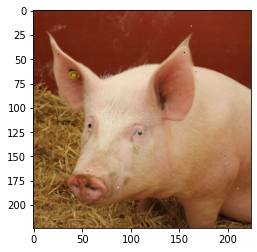

In [141]:

# plot adversary image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(candidate_to_mask(candidates[37], pig_tensor)[0].detach().numpy().transpose(1,2,0))


In [142]:
# Prediction
pred_adv = model(norm(candidate_to_mask(candidates[26], pig_tensor)))
print(imagenet_classes[pred_adv.max(dim=1)[1].item()])


hog


In [145]:
import pickle
with open(r"pixel_attack_candidates.dat", "wb") as candidates_file:
    pickle.dump(candidates, candidates_file)
with open(r"pixel_attack_losses.dat", "wb") as losses_file:
    pickle.dump(losses, losses_file)